In [1]:
#MSD calculation function from r vector
def compute_msd(trajectory, t_step, coords=[['x', 'y']]):   #for regular estimation of MSDs from the trajectories
    delays = np.arange(len(trajectory)/2) * t_step
    shifts = np.floor(delays/t_step).astype(np.int)
    msds = np.zeros(shifts.size)
    stdevs= np.zeros(shifts.size)
    for i, shift in enumerate(shifts):
        diffs = coords - coords.shift(-shift)
        sqdist = np.square(diffs).sum(axis=1, skipna=False)
        msds[i] = sqdist.mean()*0.16*0.16
        stdevs[i] =sqdist.std()
    return delays, msds, stdevs 
    
def func_normal(x, D, c):
    return 4*D*x + c

def func_anomlous(x, D, a, c):
    return 4*D*(x**a) + c

def func_active(x, D, a):
    return 4*D*x + (a**2)*x

def func_confined(x, a, C, D):
    return c*(1- a* np.exp((-4*D*x)/C))
                     
def Diffusion_coefficient (x, a, D):
    return a*np.exp(D*x)

def rotLeft(a, d): #function for rotating an array by d no. of elements
    b = []
    for i in range(-d,len(a)):
        b.append(a[i])
        b.extend(a[0:d])
    return b



In [13]:
#Boxplot function
def boxplot_func(data):
    fig, ax = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
    bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
    colors = ['hotpink', 'greenyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
 
            # changing color and linewidth of
            # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
            linewidth = 1.5,
            linestyle =":")
            # changing color and linewidth of
            # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
            linewidth = 2)
 
    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='black',
               linewidth = 3)
 
    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
        # x-axis labels
    ax.set_yticklabels(['CVE', 'MSD'])
 
    # Adding title
    plt.title("D.C. Comparison")
 
        # Removing top axes and right axes
# ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel('D (um^2/s)')
    ax.set_xscale('log')
    plt.rc('font', size=15) 
        # show plot
    plt.show()
    return ax

<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<ipython-input-1-cfabcfc827da>:18: RuntimeWarning: divide by zero encountered in power
  return 4*D*(x**a) + c
<

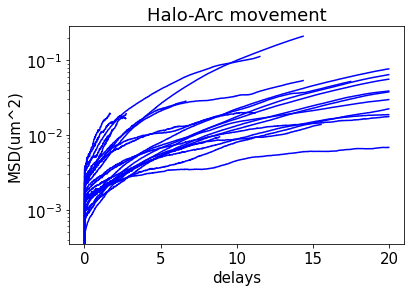

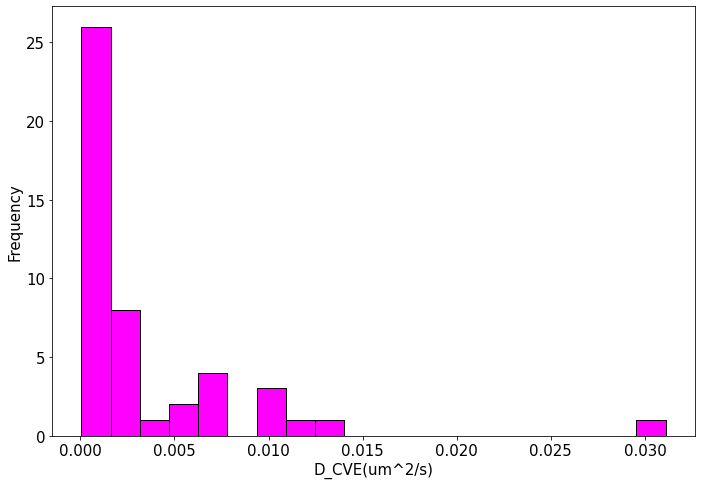

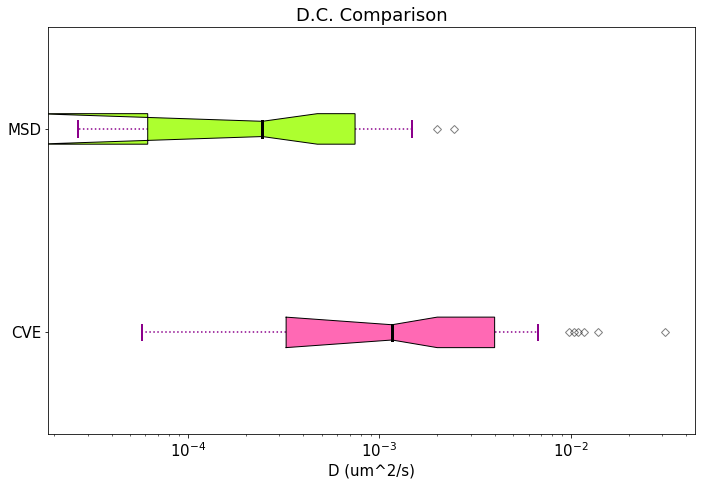

In [15]:
##Initialize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import os, fnmatch

#Open Spots files one by one in the same directory

listOfSpotsFiles = os.listdir('.')  
pattern = "20210225_Spots_HEK_haloAcUTRsC1_*.csv"  #file name
for entry in listOfSpotsFiles: #open one by one 
    if fnmatch.fnmatch(entry, pattern):
        file=pd.read_csv(entry)
        #print(file)
        cleanData = pd.DataFrame(file, columns=['TRACK_ID','POSITION_X', 
                                                'POSITION_Y','MIN_INTENSITY','MAX_INTENSITY','ESTIMATED_DIAMETER','SNR'])
        
        #keep data that is needed
        # creating subplot and figure for plotting all the data 
        fig, (ax) = plt.subplots()
        ax.set_title("Halo-Arc movement")
        ax.set_xlabel('Delay (s)')
        ax.set_ylabel('MSD (µm²)')
        ax.set_yscale('log')
        
        sortTracks = cleanData.groupby('TRACK_ID') # keep same track ids together
        D_msd_all=[]
        D_CVE_all= []
        for c in sortTracks.groups: #open one track at a time
            trackInfo = sortTracks.get_group(c)
            T = len(trackInfo) #length of one track
    
            if (T>=100): #track has to be 100 steps long to be taken into MSd analysis
                
                t_step=0.02 #the exposure/integration time in seconds
                ##MSD Analysis conventional
                coords = trackInfo[['POSITION_X', 'POSITION_Y']]
                delays, msds, stdevs = compute_msd(trackInfo, t_step=t_step, coords=coords) #computing msd from r vector
                
                #ax.plot(delays, msds, label=c)
                #plt.plot()
                #plt.legend()
                #print(delays, msds, stdevs)
                
                # Curve fitting to get DC and other parameters
                xdata = delays
                ydata = msds
                
                #plt.plot(xdata, ydata, 'b-', label='data')
                func = func_anomlous #change this to your function type
                
                #Fit for the parameters a, b, c of the function func:
                popt, pcov = curve_fit(func, xdata, ydata)
                #print(popt [1])
                
                #calculation R-square value of the fit
                
                residuals = ydata- func(xdata, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((ydata-np.mean(ydata))**2)
                r_squared = 1 - (ss_res / ss_tot)
                #print(r_squared)
                
                if (r_squared>=0.97): #selecting high R-squre values, good fits
                    plt.plot(xdata, ydata, 'b-', label='data')
                    plt.rc('font', size=15)
                    #plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: D=%5.3f, a=%5.3f, c=%5.3f,  % tuple(popt))

                    plt.xlabel('delays')
                    plt.ylabel('MSD(um^2)')
                    #plt.legend()
                    ax.set_yscale('log')
                    #plt.show()
                    
                    D_msd_all.append(popt[0])
    #calculating DC with CVE method, as done in Saurabh's paper for all the tracks
                
                diff_xn = np.diff(trackInfo.POSITION_X) #this calculates x(n+1)-x(n)
                length_diff = diff_xn.size-1 #number of elements in covariance estimator average for both x and y positions
                diff_xn1= rotLeft(diff_xn,1) #this calculates x(n+2)-x(n+1)
                diff_xn1 = np.asarray(diff_xn1) #list to array
                prod_xn_xn1 = np.multiply(diff_xn[: length_diff], diff_xn1[:length_diff]) #multiplying n-1 elements in xn and xn1
                diff_xn_square = np.mean(diff_xn**2) #mean over time series squared
                
                diff_yn = np.diff(trackInfo.POSITION_Y)
                diff_yn1= rotLeft(diff_yn,1)
                diff_yn1 = np.asarray(diff_yn1)
                prod_yn_yn1 = np.multiply(diff_yn[: length_diff], diff_yn1[:length_diff]) 
                diff_yn_square = np.mean(diff_yn**2)
                
                D_CVE_x = ((diff_xn_square/(2+t_step)) + (np.mean(prod_xn_xn1)/(t_step)))*(0.16**2) #for x
                D_CVE_y = ((diff_yn_square/(2+t_step)) + (np.mean(prod_yn_yn1)/(t_step)))*(0.16**2) #for y
                D_CVE = abs((D_CVE_x +D_CVE_y) /2) #total diffusion coefficient
                #print(D_CVE)
                D_CVE_all.append(D_CVE)
                #going ahead, x is delay and y is msd
                
                #selected histogram for DCVR
        fig, axs_DCVE = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
        axs_DCVE.hist(D_CVE_all, bins = 20, density=False, color= "magenta",edgecolor='black')
        axs_DCVE.set_xlabel('D_CVE(um^2/s)')
        axs_DCVE.set_ylabel('Frequency')
        plt.rc('font', size=15)
        plt.show
        lg_D_CVE= np.log10(D_CVE_all)
        lg_D_msd= np.log10(D_msd_all)
        
        data_DC=[D_CVE_all,D_msd_all]
        data_DC_lg=[lg_D_CVE,lg_D_msd]
             #selected histogram for MSD based DC estimation
        #fig, axs_D_msd = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
        #axs_D_msd.hist(D_msd_all, bins = None, density=False, color= "magenta",edgecolor='black')
        #axs_D_msd.set_xlabel('D_msd(um^2/s)')
        #axs_D_msd.set_ylabel('Frequency')
        #plt.show 
                
                
#                 #finalizing final fit and type of movement
                            
        ax_all = boxplot_func(data_DC) 
        #ax_all = boxplot_func(data_DC_lg) 
        


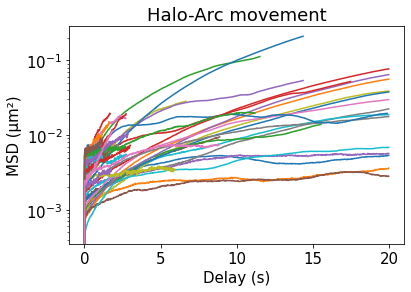

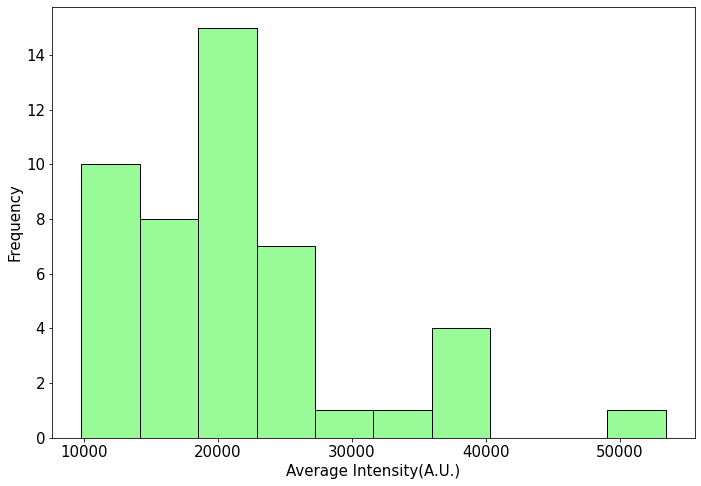

In [78]:
##Initialize for curve fitting method

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import os, fnmatch

#Open Spots files one by one in the same directory

listOfSpotsFiles = os.listdir('.')  
pattern = "20210225_Spots_HEK_haloAcUTRsC1_*.csv"  
for entry in listOfSpotsFiles: #open one by one 
    if fnmatch.fnmatch(entry, pattern):
        file=pd.read_csv(entry)
        #print(file)
        cleanData = pd.DataFrame(file, columns=['TRACK_ID','POSITION_X', 'POSITION_Y','MIN_INTENSITY','MAX_INTENSITY','ESTIMATED_DIAMETER','SNR'])
        #keep data that is needed
        
        # creating subplot and figure for plotting MSD data 
        fig, (ax) = plt.subplots()
        ax.set_title("Halo-Arc movement")
        ax.set_xlabel('Delay (s)')
        ax.set_ylabel('MSD (µm²)')
        ax.set_yscale('log')
        
        sortTracks = cleanData.groupby('TRACK_ID') # keep same track ids together
        Avg_intensity_list=[] #for storing average Intensities
        for c in sortTracks.groups: #open one track at a time
            trackInfo = sortTracks.get_group(c)
            T = len(trackInfo) #length of one track
            
            if (T>=100): #track has to be 100 steps long to be taken into MSd analysis
                
                t_step=0.02 #the exposure/integration time in seconds
                ##MSD Analysis conventional
                coords = trackInfo[['POSITION_X', 'POSITION_Y']]
                
                Avg_intensity= sum(trackInfo['MAX_INTENSITY'])/T
                Avg_intensity_list.append(Avg_intensity)
                #print(Avg_intensity_list)
                
                #MSD calculation
                delays, msds, stdevs = compute_msd(trackInfo, t_step=t_step, coords=coords) #computing msd from r vector
                ax.plot(delays, msds, label=c)
                plt.rc('font', size=15)
                #plt.fill_between(delays, msds-stdevs,  msds+stdevs, alpha=0.6)
                plt.plot()
                
        #plot Intensity
        fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
        axs.hist(Avg_intensity_list, bins = 10, density=False, color= "palegreen",edgecolor='black')
        axs.set_xlabel('Average Intensity(A.U.)')
        axs.set_ylabel('Frequency')
        plt.rc('font', size=15)
        plt.show      